# ¿Que más se podría hacer?

- Test con data augmentation y la LSTM
- Usar los tokenizadores usados en los transformers para ver como funcionan
- TSNE de embeddings y analizar si hay interpretación
- Probar con otras encimas o proteinas
- Usar los embeddings entrenados para analizar resultados de proteinas o encimas con menos data
- Entrenar una red neuronal con los features (fingerprints por ejemplo) y comparar los resultados con los embeddings


# Tome cualquiera de estas propuestas o alguna suya y desarrolle

- Test con data augmentation y la LSTM

In [7]:
import pandas as pd
import numpy as np
from rdkit import Chem
from datagen import smiles_dict, smiles_to_seq

In [8]:
from dataaug import SmilesEnumerator

In [9]:
df = pd.read_csv('data/acetylcholinesterase_02_bioactivity_data_preprocessed.csv')

In [10]:
df.head(5)

,molecule_chembl_id,canonical_smiles,standard_value,standard_value_norm,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,750.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,100.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,50000.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,300.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,800.0,6.096910


In [15]:
X = df['canonical_smiles'].values
y = df['pIC50'].values

In [16]:
len(X),range(len(X)-1)

(5824, range(0, 5823))

In [17]:
sme = SmilesEnumerator()

In [18]:
for i in range(len(X)):
    if i==0:
        x1=np.array(sme.randomize_smiles(X[i]))
    else:
        x1=np.append(x1, np.array(sme.randomize_smiles(X[i])))

In [19]:
for i in range(len(X)):
    if i==0:
        x2=np.array(sme.randomize_smiles(X[i]))
    else:
        x2=np.append(x2, np.array(sme.randomize_smiles(X[i])))

In [20]:
x1[50],X[50],x2[50]

('COc1ccc(C(=O)/C(SCC[N+](C)(C)C)=N/O)cc1.[Cl-]',
 'COc1ccc(C(=O)/C(=N/O)SCC[N+](C)(C)C)cc1.[Cl-]',
 'C(S/C(C(=O)c1ccc(OC)cc1)=N\\O)C[N+](C)(C)C.[Cl-]')

## Son estas moleculas iguales?

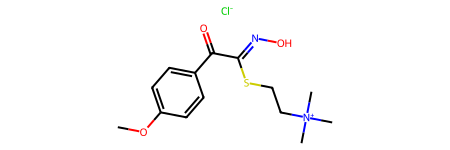

In [21]:
Chem.MolFromSmiles(X[50])

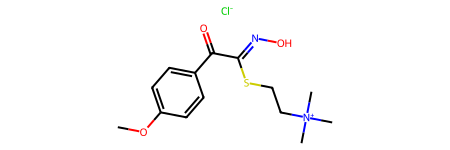

In [22]:
Chem.MolFromSmiles(x1[50])


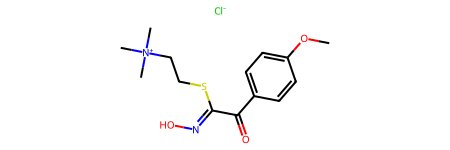

In [23]:
Chem.MolFromSmiles(x2[50])

In [24]:
X=np.append(X,x1)

In [25]:
X=np.append(X,x2)

In [26]:
X.shape,x1.shape,5824*3

((17472,), (5824,), 17472)

In [27]:
y1 = np.hstack([y, y])

In [28]:
y= np.hstack([y1, y])

In [29]:
y[50],y[5824+50],y[2*5824+50],X[50],X[5824+50],X[2*5824+50]

(3.0,
 3.0,
 3.0,
 'COc1ccc(C(=O)/C(=N/O)SCC[N+](C)(C)C)cc1.[Cl-]',
 'COc1ccc(C(=O)/C(SCC[N+](C)(C)C)=N/O)cc1.[Cl-]',
 'C(S/C(C(=O)c1ccc(OC)cc1)=N\\O)C[N+](C)(C)C.[Cl-]')

In [30]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
token=Tokenizer(char_level=True, lower=False)
token.fit_on_texts(X)
token.word_index

{'c': 1,
 'C': 2,
 '(': 3,
 ')': 4,
 '1': 5,
 'O': 6,
 '2': 7,
 'N': 8,
 '=': 9,
 '3': 10,
 '[': 11,
 ']': 12,
 'n': 13,
 '@': 14,
 '4': 15,
 'H': 16,
 '-': 17,
 '/': 18,
 'l': 19,
 '.': 20,
 '+': 21,
 'F': 22,
 '5': 23,
 'o': 24,
 'B': 25,
 'r': 26,
 'S': 27,
 '\\': 28,
 '#': 29,
 's': 30,
 '6': 31,
 'I': 32,
 'e': 33,
 'P': 34,
 '7': 35,
 '8': 36,
 'i': 37,
 'a': 38,
 '9': 39}

In [31]:
X_seq = token.texts_to_sequences(X)

In [32]:
X_seq_pad = pad_sequences(X_seq)

# Split

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_seq_pad, y, test_size=0.2, random_state=42)

In [35]:
X_train = np.vstack([X_train, X_train[:, ::-1]])

In [36]:
y_train = np.hstack([y_train, y_train])

In [37]:
X_train.shape,y_train.shape

((27954, 209), (27954,))

# Network Model

In [38]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout, Activation, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K

In [39]:
# Métrica

def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [40]:
vocab_size = len(token.word_index)
vocab_size

39

In [41]:
max_sequence_len = X_seq_pad.shape[1]
max_sequence_len

209

In [42]:
model = Sequential()
model.add(Embedding(vocab_size + 1, 64, input_length=max_sequence_len))
model.add(Bidirectional(LSTM(128, return_sequences=False, activation='tanh')))
model.add(Dense(100))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(1, activation='linear'))

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 209, 64)           2560      
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               197632    
_________________________________________________________________
dense (Dense)                (None, 100)               25700     
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5

In [124]:
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse', metrics=[R2])

In [136]:
mcp = ModelCheckpoint('models/best_model_{epoch}.h5', save_best_only=True)
lr_reduce = ReduceLROnPlateau(monitor='loss', 
                                   factor=0.1,
                                   cooldown=0,
                                   patience=3,
                                   min_lr=1e-4)
ES=EarlyStopping(monitor='val_loss',patience=7, restore_best_weights=True)

In [128]:
y_train.shape

(27954,)

In [140]:
history = model.fit(X_train, y_train,epochs=10, batch_size=100,  validation_data=(X_test, y_test), callbacks=[mcp, ES,lr_reduce])

Epoch 1/10
280/280 [==============================] - 600s 2s/step - loss: 0.4383 - R2: 0.8309 - val_loss: 1.0185 - val_R2: 0.6143
Epoch 2/10
280/280 [==============================] - 602s 2s/step - loss: 0.4264 - R2: 0.8360 - val_loss: 1.1102 - val_R2: 0.5819
Epoch 3/10
280/280 [==============================] - 614s 2s/step - loss: 0.4195 - R2: 0.8387 - val_loss: 0.9968 - val_R2: 0.6264
Epoch 4/10
280/280 [==============================] - 610s 2s/step - loss: 0.4082 - R2: 0.8431 - val_loss: 1.1266 - val_R2: 0.5772
Epoch 5/10
280/280 [==============================] - 592s 2s/step - loss: 0.3932 - R2: 0.8489 - val_loss: 0.9689 - val_R2: 0.6378
Epoch 6/10
280/280 [==============================] - 540s 2s/step - loss: 0.3851 - R2: 0.8517 - val_loss: 1.0141 - val_R2: 0.6229
Epoch 7/10
280/280 [==============================] - 495s 2s/step - loss: 0.3861 - R2: 0.8515 - val_loss: 0.9544 - val_R2: 0.6369
Epoch 8/10
280/280 [==============================] - 496s 2s/step - loss: 0.3814 -

In [130]:
y_pred = model.predict(X_test)

# Score

In [132]:
r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()
r2

0.5871711952008821

In [133]:
model.save('model.h5', )

# Load model

In [2]:
from tensorflow.keras.models import load_model

In [3]:
filename_best_model = 'models/best_model_7.h5'

In [6]:
model_loaded_modif = load_model(filename_best_model, custom_objects={'R2': R2})

In [ ]:
y_pred = model_loaded_modif.predict(X_test)

In [ ]:
r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()
r2

# Evaluation

<function matplotlib.pyplot.show(*args, **kw)>

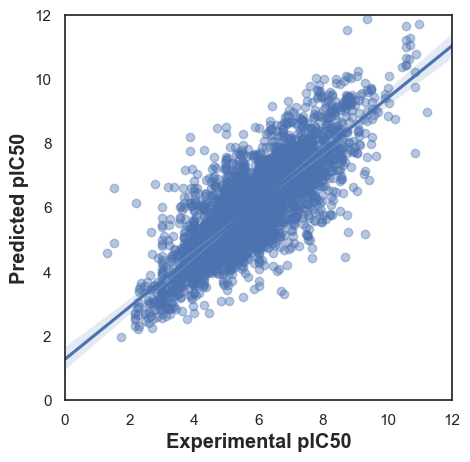

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show